In [1]:
import os
import sys
import pickle

PROJECT_ROOT = os.path.abspath('..')
sys.path.append(PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

RESULTS_PATH = os.path.join(PROJECT_ROOT, 'results')

/home/ntapia/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Max amplitude preliminaries

In [2]:
mass = load_dataset('mass_kc')
signals = mass.get_signals(normalize_clip=False)
marks = mass.get_stamps(pages_subset='n2')

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.672256619001445


In [3]:
all_kc_min = []
all_kc_max = []
for sub_signal, sub_marks in zip(signals, marks):
    kc = [sub_signal[m[0]:m[1]+1] for m in sub_marks]
    kc_min = np.array([np.min(s) for s in kc])
    kc_max = np.array([np.max(s) for s in kc])
    all_kc_min.append(kc_min)
    all_kc_max.append(kc_max)
all_kc_min = np.concatenate(all_kc_min)
all_kc_max = np.concatenate(all_kc_max)
print(all_kc_min.shape, all_kc_max.shape)

(8781,) (8781,)


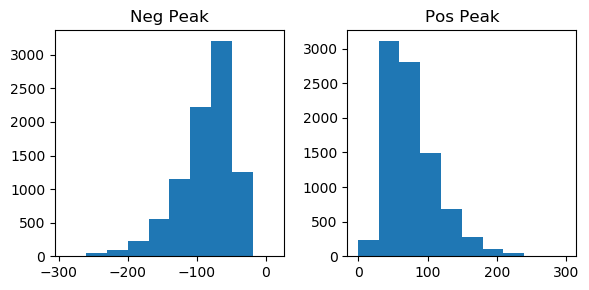

Negative Peak prct 98: -195.3645 uV
Positive Peak prct 98: 178.4423 uV


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=100)
ax = axes[0]
ax.hist(all_kc_min)
ax.set_title("Neg Peak")
ax = axes[1]
ax.hist(all_kc_max)
ax.set_title("Pos Peak")
plt.tight_layout()
plt.show()

prct = 98

print("Negative Peak prct %d: %1.4f uV" % (prct, np.percentile(all_kc_min, 100-prct)))
print("Positive Peak prct %d: %1.4f uV" % (prct, np.percentile(all_kc_max, prct)))

# NSRR EXPLORATION

In [9]:
class PredictedNSRR(object):
    def __init__(
        self,
        experiment_folder='20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
        grid_folder='v2_time',
        page_duration=30,
        min_separation=0.3,
        min_duration=0.3,
        max_duration=3.0,
    ):
        self.experiment_folder = experiment_folder
        self.grid_folder = grid_folder
        self.subject_to_fold_map = self._hash_predictions()
        self.all_ids = np.sort(list(self.subject_to_fold_map.keys()))        
        self.post_params = {
            pkeys.PAGE_DURATION: page_duration,
            pkeys.SS_MIN_SEPARATION: min_separation,
            pkeys.SS_MIN_DURATION: min_duration,
            pkeys.SS_MAX_DURATION: max_duration,
        }

    def get_predictions(self, fold_ids_list, dataset, threshold=0.5):
        proba_dict = {}
        for fold_id in fold_ids_list:
            t_proba_dict = self.get_fold_probabilities(fold_id)
            proba_dict.update(t_proba_dict)
        subject_ids = list(proba_dict.keys())
        subject_ids.sort()
        feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=1)
        feed_d.unknown_id = dataset.unknown_id
        feed_d.n2_id = dataset.n2_id
        feed_d.original_page_duration = dataset.original_page_duration
        prediction = PredictedDataset(
            dataset=feed_d,
            probabilities_dict=proba_dict,
            params=self.post_params.copy(), skip_setting_threshold=True)
        prediction.set_probability_threshold(threshold)
        return prediction
        
    def get_subject_fold(self, subject_id):
        return self.subject_to_fold_map[subject_id]
    
    def get_fold_probabilities(self, fold_id):
        pred_path = os.path.join(RESULTS_PATH, 'predictions_nsrr_ss', self.experiment_folder, self.grid_folder)
        fold_path = os.path.join(pred_path, 'fold%d' % fold_id, 'prediction_n2_test.pkl')
        with open(fold_path, 'rb') as handle:
            proba_dict = pickle.load(handle)
        return proba_dict
    
    def _hash_predictions(self):
        pred_path = os.path.join(RESULTS_PATH, 'predictions_nsrr_ss', self.experiment_folder, self.grid_folder)
        folds = os.listdir(pred_path)
        folds = [int(f.split("fold")[-1]) for f in folds]
        folds = np.sort(folds)
        
        subject_to_fold_map = {}
        for fold_id in folds:
            proba_dict = self.get_fold_probabilities(fold_id)
            fold_subjects = list(proba_dict.keys())
            for subject_id in fold_subjects:
                subject_to_fold_map[subject_id] = fold_id
        return subject_to_fold_map

In [10]:
nsrr_preds = PredictedNSRR()

In [11]:
nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True)

Dataset nsrr_ss with 3 patients.
Loading from checkpoint... Loaded
Global STD: None
Dataset nsrr_ss with 11593 patients.


# Reproducción de tendencias

In [12]:
n_folds = 10

fold_ids_list = np.arange(n_folds)
predictions = nsrr_preds.get_predictions(fold_ids_list, nsrr, threshold=0.3)

print("Loaded predictions for %d subjects" % len(predictions.all_ids))

Loaded predictions for 1000 subjects


In [13]:
min_n2_minutes = 60

subject_ids = predictions.all_ids

table_byevent = {'duration': []}
table_bysubject = {
    'subject_id': [], 
    'duration': [], 'density': [], 'proba_event': [], 
    'n2_minutes': [], 'origin': [],
    'age': [], 'female': []
}
for i in range(len(subject_ids)):
    subject_id = subject_ids[i]
    n2_pages = predictions.data[subject_id]['n2_pages']
    n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
    if n2_minutes < min_n2_minutes:
        print("Skipped by N2 minutes: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
        continue
    
    marks = predictions.get_subject_stamps(subject_id)
    
    n_marks = marks.shape[0]
    if n_marks == 0:
        print("Skipped by Marks     : Subject %s with %d marks (%d N2 minutes)" % (subject_id, n_marks, n2_minutes))
        continue

    durations = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs
    
    # Remove durations greater than 2.96
    # so that we simply remove spindles greater than 3 instead of trying to fix them
    valid_locs = durations < 3.0
    marks = marks[valid_locs]
    durations = durations[valid_locs]
    
    n_marks = marks.shape[0]
    if n_marks == 0:
        print("Skipped by Marks (post): Subject %s with %d marks (%d N2 minutes)" % (subject_id, n_marks, n2_minutes))
        continue
    
    subject_proba = predictions.get_subject_stamps_probabilities(subject_id)
    subject_proba = subject_proba[valid_locs]
    
    subject_mean_duration = np.mean(durations)
    subject_density = n_marks / n2_minutes
    subject_mean_proba = np.mean(subject_proba)
    subdataset = subject_id[:-4]
    
    subject_data = nsrr.read_subject_data(subject_id)
    age = float(subject_data['age'].item())
    female = int(subject_data['sex'].item() == 'f')
    
    table_byevent['duration'].append(durations)
    table_bysubject['subject_id'].append(subject_id)
    table_bysubject['duration'].append(subject_mean_duration)
    table_bysubject['density'].append(subject_density)
    table_bysubject['proba_event'].append(subject_mean_proba)
    table_bysubject['n2_minutes'].append(n2_minutes)
    table_bysubject['origin'].append(subdataset)
    table_bysubject['age'].append(age)
    table_bysubject['female'].append(female)
    
for key in table_byevent:
    table_byevent[key] = np.concatenate(table_byevent[key])
table_byevent = pd.DataFrame.from_dict(table_byevent)
table_bysubject = pd.DataFrame.from_dict(table_bysubject)
print("Done.")

Skipped by N2 minutes: Subject cfs-visit5-800393 with 45 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-300365 with 28 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300521 with 0 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300607 with 0 N2 minutes
Skipped by N2 minutes: Subject mros-visit1-aa0965 with 27 N2 minutes
Skipped by N2 minutes: Subject mros-visit1-aa5622 with 14 N2 minutes
Skipped by N2 minutes: Subject shhs1-200489 with 24 N2 minutes
Skipped by N2 minutes: Subject shhs1-201788 with 28 N2 minutes
Skipped by N2 minutes: Subject shhs1-202005 with 31 N2 minutes
Skipped by N2 minutes: Subject shhs1-202274 with 59 N2 minutes
Skipped by N2 minutes: Subject shhs1-202444 with 37 N2 minutes
Skipped by Marks     : Subject shhs1-202456 with 0 marks (130 N2 minutes)
Skipped by N2 minutes: Subject sof-visit-8-02027 with 25 N2 minutes
Done.


In [14]:
table_byevent

,duration
0,0.60
1,0.76
2,1.56
3,0.44
4,0.76
...,...
280602,0.56
280603,0.60
280604,0.44
280605,0.96


In [15]:
table_bysubject

,subject_id,duration,density,proba_event,n2_minutes,origin,age,female
0,ccshs-trec-1800034,1.166541,6.100251,0.938424,199.5,ccshs-trec-180,17.40,1
1,ccshs-trec-1800038,1.183077,5.032258,0.908524,232.5,ccshs-trec-180,17.40,1
2,ccshs-trec-1800065,1.015436,3.729412,0.903289,255.0,ccshs-trec-180,17.68,1
3,ccshs-trec-1800074,0.929716,3.725159,0.884679,236.5,ccshs-trec-180,17.86,1
4,ccshs-trec-1800078,0.900645,3.256566,0.867593,247.5,ccshs-trec-180,17.77,0
...,...,...,...,...,...,...,...,...
982,sof-visit-8-09018,0.806644,1.421687,0.906736,207.5,sof-visit-8-0,81.00,1
983,sof-visit-8-09036,0.777490,1.128755,0.862540,233.0,sof-visit-8-0,81.00,1
984,sof-visit-8-09614,1.018947,1.163265,0.755609,98.0,sof-visit-8-0,83.00,1
985,sof-visit-8-09627,0.789737,1.375566,0.819841,110.5,sof-visit-8-0,82.00,1


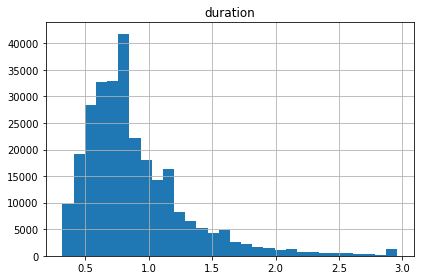

In [16]:
# by-event stuff
table_byevent.hist(bins=30)
plt.tight_layout()
plt.show()

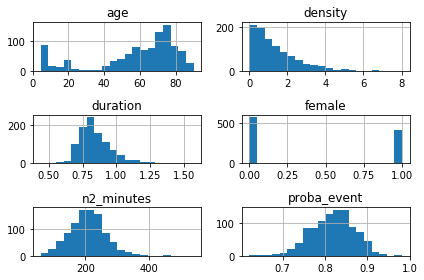

In [17]:
table_bysubject.hist(bins=20)
plt.tight_layout()
plt.show()

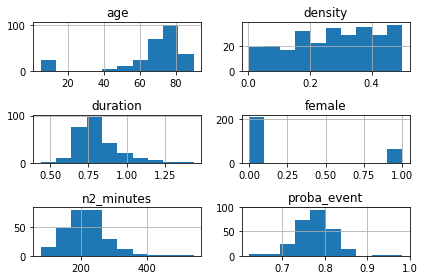

In [18]:
zoom_density = 0.5

table_zoom = table_bysubject[table_bysubject.density < zoom_density]
table_zoom.hist()
plt.tight_layout()
plt.show()

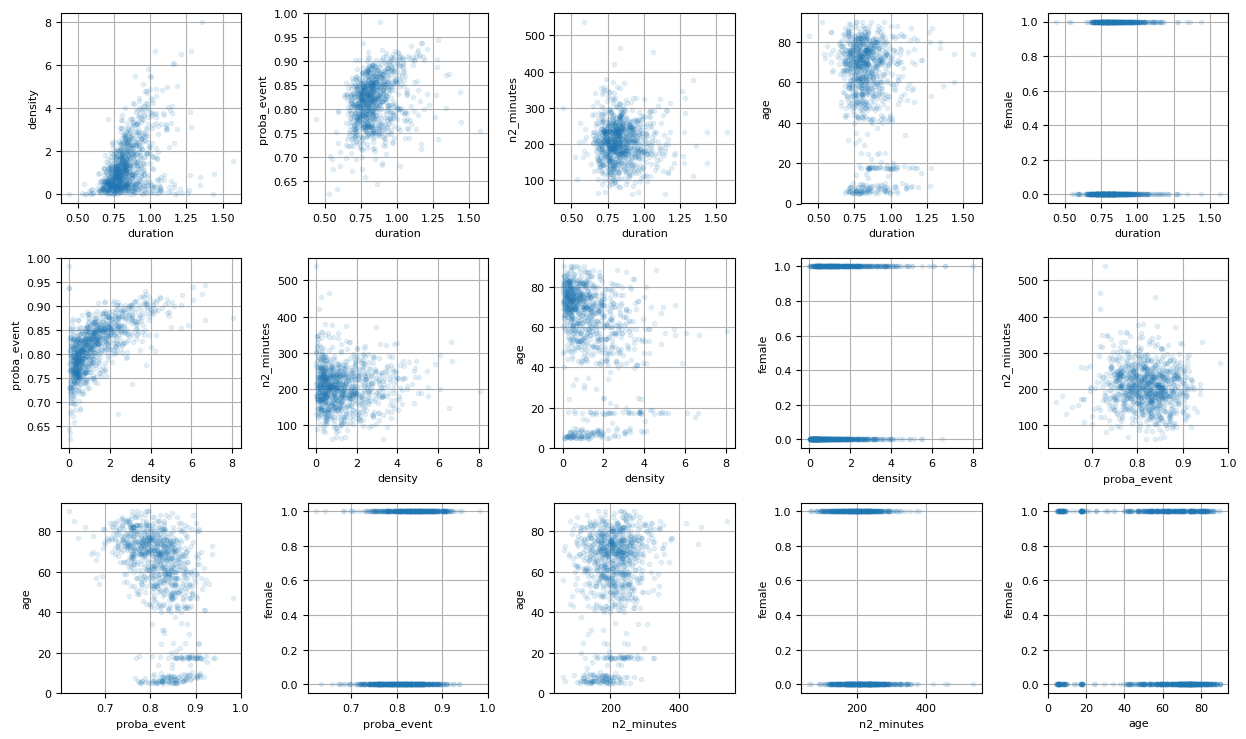

In [19]:
# correlations

param_names = table_bysubject.select_dtypes(include=np.number).columns.tolist()
n_params = len(param_names)
n_plots = n_params * (n_params - 1) / 2
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows* 2.5), dpi=100)
axes = axes.flatten()
global_count = -1
for i in range(n_params):
    for j in range(i + 1, n_params):
        global_count += 1
        ax = axes[global_count]
        
        x_data = table_bysubject[param_names[i]].values
        y_data = table_bysubject[param_names[j]].values
        
        ax.plot(x_data, y_data, linestyle="none", marker='o', markersize=3, alpha=0.1)
        ax.set_xlabel(param_names[i], fontsize=8)
        ax.set_ylabel(param_names[j], fontsize=8)
        
        ax.tick_params(labelsize=8)
        ax.grid()
plt.tight_layout()
plt.show()

In [78]:
table_bysubject[table_bysubject.duration > 2]

,subject_id,duration,density,proba_event,n2_minutes,origin,age,female
588,shhs1-201711,2.12,0.017241,0.912292,232.0,shhs1-20,60.0,0


In [74]:
# estrategia:
# Podria elegir un umbral para cada grupo etareo, partir de 0.5 pero bajarlo hasta que la media del by-subject proba-event en cada grupo etareo sea similar
# Esto para corregir el tema de las demasiado bajas densidades que se concentra en los mas viejos (mros, shhs, y sof) ¿Y si no es edad sino dataset?


# Check single subject

In [79]:
subject_id = 'shhs1-201711'  # 'sof-visit-8-02332'

signal = nsrr.get_subject_signal(subject_id, normalize_clip=False)
n2_pages = predictions.data[subject_id]['n2_pages']
n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
marks = predictions.get_subject_stamps(subject_id)
durations = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs

# Remove durations greater than 2.96
# so that we simply remove spindles greater than 3 instead of trying to fix them
valid_locs = durations < 3.0
marks = marks[valid_locs]
durations = durations[valid_locs]

In [88]:
n2_pages

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        15,  16,  17,  19,  20,  21,  22,  23,  25,  26,  28,  30,  32,
        33,  35,  38,  41,  44,  47,  50,  53,  54,  55,  56,  57,  58,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       140, 141, 142, 143, 145, 147, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 20

In [81]:
marks

array([[  21552,   21935],
       [ 811328,  811455],
       [1194472, 1195063],
       [1981104, 1981695]], dtype=int32)

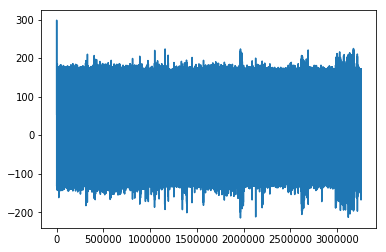

In [89]:
plt.plot(signal)
plt.show()

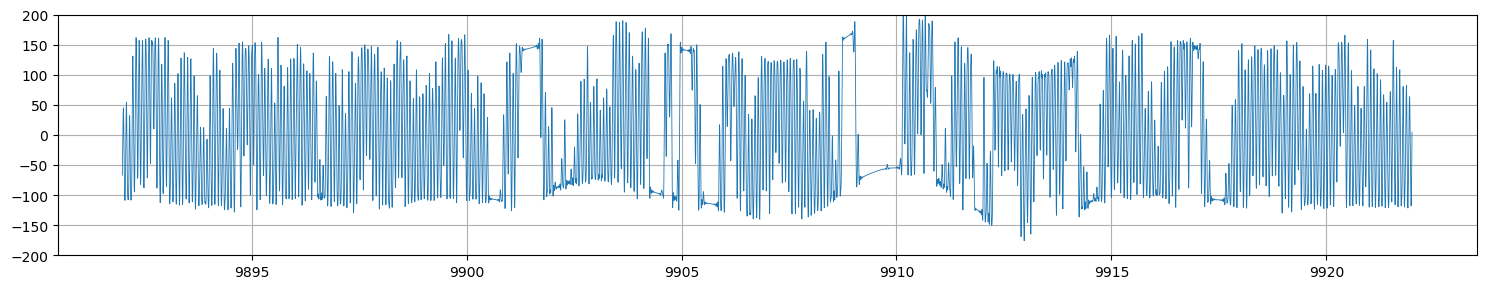

In [93]:
center_sample = marks[3].mean()

window_duration = 30
window_size = nsrr.fs * window_duration
start_sample = int(center_sample - window_size // 2)
end_sample = int(start_sample + window_size)
time_axis = np.arange(start_sample, end_sample) / nsrr.fs

fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=100)
ax.plot(time_axis, signal[start_sample:end_sample], linewidth=.6)
ax.set_ylim([-200, 200])
ax.grid()

plt.tight_layout()
plt.show()

In [94]:
x = signal.reshape(-1, nsrr.original_page_duration * nsrr.fs)[n2_pages].flatten()
freq, power = utils.power_spectrum_by_sliding_window(x, nsrr.fs)

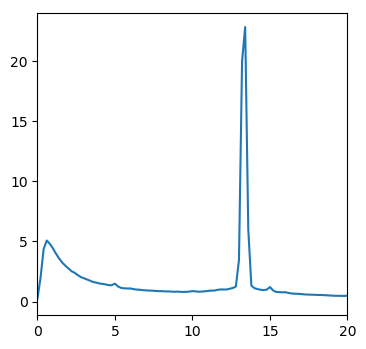

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
ax.plot(freq, power)
ax.set_xlim([0, 20])
plt.show()

In [97]:
spectra = []
for subject_id in predictions.all_ids:
    signal = nsrr.get_subject_signal(subject_id, normalize_clip=False)
    n2_pages = predictions.data[subject_id]['n2_pages']
    n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
    
    if n2_minutes < 60:
        continue
    
    marks = predictions.get_subject_stamps(subject_id)
    durations = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs

    # Remove durations greater than 2.96
    # so that we simply remove spindles greater than 3 instead of trying to fix them
    valid_locs = durations < 3.0
    marks = marks[valid_locs]
    durations = durations[valid_locs]
    
    x = signal.reshape(-1, nsrr.original_page_duration * nsrr.fs)[n2_pages].flatten()
    freq, power = utils.power_spectrum_by_sliding_window(x, nsrr.fs)
    spectra.append(power)

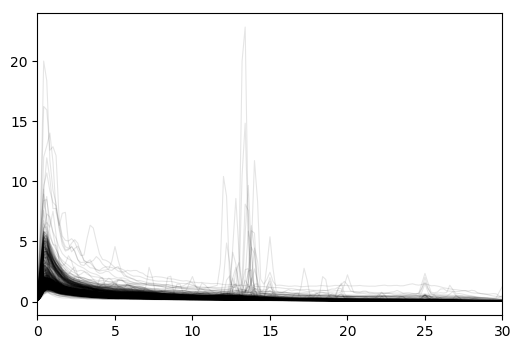

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
for power in spectra:
    ax.plot(freq, power, color="k", alpha=0.1, linewidth=0.8)
    ax.set_xlim([0, 30])
plt.show()